In [2]:
import enum
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

In [3]:
class AgentType(enum.Enum):
    Early = 1
    Late = 0

In [81]:
class Agent:
    def __init__(self, q: float, agent_type: AgentType, id: int, p_panic:float=0.):
        """
        q -- threshold level from 0.0 to 1.0
        p_panic -- probability that Late will need to withdraw funds earlier
        """
        self.q = np.random.uniform(0.5*q, 1.5*q)
        self.agent_type = agent_type
        self._neighbours = list()
        self.id = id    
        self.p_panic = p_panic
        
        if self.agent_type == AgentType.Early:
            self.action = 0
        else:
            self.action = 1 if np.random.rand() < self.p_panic else 0
    
    @property
    def received_signal(self):
        if self.neighbours:
            return np.mean([n.action for n in self.neighbours if n.agent_type == AgentType.Late])
        return 0
    
    @property
    def neighbours(self):
        return self._neighbours
    
    @neighbours.setter
    def neighbours(self, agents: list):
        if list(filter(lambda x: not isinstance(x, Agent), agents)):
            raise TypeError('All neighbours must be Agents')
        self._neighbours = agents
    
    def update(self):
        if self.received_signal > self.q and self.agent_type == AgentType.Late:
            self.action = 1
    
    def __repr__(self):
        return f"Agent({self.q}, AgentType.{self.agent_type.name}, id={self.id})"

In [82]:
user_1 = Agent(0.5, AgentType.Early, 1)
user_2 = Agent(0.5, AgentType.Early, 2)
user_3 = Agent(0.5, AgentType.Late, 3)
user_4 = Agent(0.7, AgentType.Late, 4)

user_3.neighbours = [user_1, user_2, user_4]
user_3.action
user_3.update()
user_3.action

user_4.neighbours = [user_3]
user_4.action
user_4.update()
user_4.action

0

In [83]:
user_4

Agent(0.5608457754154857, AgentType.Late, id=4)

In [84]:
def build_legend(data):
    """
    Build a legend for matplotlib plt from dict
    """
    legend_elements = []
    for key in data:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=key,
                                        markerfacecolor=data[key], markersize=10))
    return legend_elements

In [85]:
class Game:
    def __init__(self, n: int, p: float, q: float, D: int, r1: float, p_panic: float):
        """
        q -- threshold level from 0.0 to 1.0
        p -- probability of agent to be Early
        n -- size. The lattice has the form n x n
        D -- neighbours radius
        r1 -- bank return for early withdrawal
        """
        self.q, self.n, self.p, self.D, self.r1, self.p_panic = q, n, p, D, r1, p_panic
        self.matrix = np.empty((self.n, self.n), dtype=Agent)
        
        # initiating types
        types = np.random.rand(self.n, self.n) < self.p
        for i in range(self.n):
            for j in range(self.n):
                type_ij = AgentType.Early if types[i, j] else AgentType.Late
                id = (i+1) * 10**(int(np.log10(j+1))+1) + (j + 1)
                self.matrix[i, j] = Agent(self.q, type_ij, id, p_panic)
        
        # set neighbours
        for i in range(self.n):
            for j in range(self.n):
                neighbour_agents = set()
                for a in range(self.D + 1):
                    for b in range(self.D + 1):
                        if a + b <= self.D and a + b > 0:
                            # left and up
                            if j - a >= 0 and i - b >= 0:
                                neighbour_agents.add(self.matrix[i-b, j-a])
                            # left and down
                            if j - a >= 0 and i + b < self.n:
                                neighbour_agents.add(self.matrix[i+b, j-a])
                            # right and up
                            if j + a < self.n and i - b >= 0:
                                neighbour_agents.add(self.matrix[i-b, j+a])
                            # right and down
                            if j + a < self.n and i + b < self.n:
                                neighbour_agents.add(self.matrix[i+b, j+a])
                self.matrix[i, j].neighbours = list(neighbour_agents)
    
    def play_once(self):
        changes = 0
        for i in range(self.n):
            for j in range(self.n):
                agent = self.matrix[i, j]
                init_action = agent.action
                agent.update()
                new_action = agent.action
                changes += abs(new_action - init_action)
        return changes
    
    def play_until_convergence(self):
        iters = 1
        while self.play_once() != 0:
            iters += 1
        return {'iters': iters, 'is_bank_run': self.is_bank_run()}
                                    
    def get_agent_lattice(self):
        get_type = np.vectorize(lambda x: 1 if x.agent_type == AgentType.Early else 0)
        return get_type(self.matrix)
    
    def get_action_lattice(self):
        get_action = np.vectorize(lambda x: 1 if x.agent_type == AgentType.Early else x.action)
        return get_action(self.matrix)

    def get_id_lattice(self):
        get_id = np.vectorize(lambda x: x.id)
        return get_id(self.matrix)

    def get_agent_action_lattice(self):
        action_lattice = self.get_action_lattice()*10
        agent_lattice = self.get_agent_lattice()
        
        agent_action_lattice = action_lattice + agent_lattice
        
        m = np.vectorize(lambda x: 0 if x == 0 else 1 if x == 11 else 2)
        
        return m(agent_action_lattice)
    
    def plot(self, data, legend):
        # define color map 
        color_map = {0: np.array([255, 0, 0]), # red -- late
                    1: np.array([0, 255, 0]), # green -- early
                    2: np.array([0, 0, 255])} # blue -- late who wish to withdraw 

        # make a 3d numpy array that has a color channel dimension   
        data_3d = np.ndarray(shape=(data.shape[0], data.shape[1], 3), dtype=int)
        for i in range(0, data.shape[0]):
            for j in range(0, data.shape[1]):
                data_3d[i][j] = color_map[data[i][j]]
        
        plt.imshow(data_3d)
        legend_elements = build_legend(legend)
        plt.legend(handles=legend_elements, loc='upper left')
        plt.show()
    
    def plot_agent_lattice(self):
        self.plot(self.get_agent_lattice(), {'Late':'Red','Early':'Green'})
    
    def plot_agent_action_lattice(self):
        self.plot(self.get_agent_action_lattice(), {'Late':'Red','Early':'Green', 'Withdraw':'Blue'})
    
    def is_bank_run(self):
        return self.get_action_lattice().sum() * self.r1 > self.n ** 2
    
    def exog_shock(self, idx: np.array):
        """
        idx - zero / one matrix of shape n by n to make corresponding Late
        clients withdraw their funds earlier
        """
        assert ((idx == 0) | (idx == 1)).all()
        for agent in self.matrix[idx.astype(bool)]:
            if agent.agent_type == AgentType.Late:
                agent.action = 1

# Simulations

## Without exogenous shock

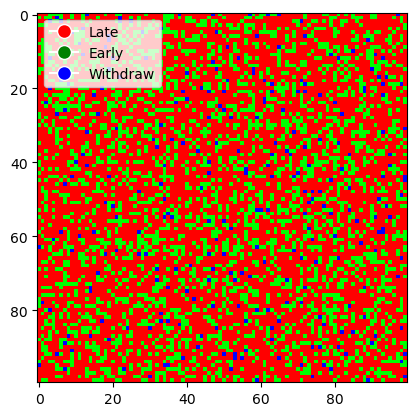

In [ ]:
n = 100
p = 0.3
q = 0.33
D = 2
r1 = 1.5
p_panic = 0.04

game = Game(n, p, q, D, r1, p_panic)
game.plot_agent_action_lattice()

In [12]:
runs = list()
iters = list()

n = 100
p = 0.3
q = 0.33
D = 2
r1 = 1.5
p_panic = 0.04

for _ in range(100):
    game = Game(n, p, q, D, r1, p_panic)
    res = game.play_until_convergence()
    runs.append(res['is_bank_run'])
    iters.append(res['iters'])
    

In [15]:
np.mean(runs)

0.0

In [14]:
np.mean(iters)

8.03

## With shock

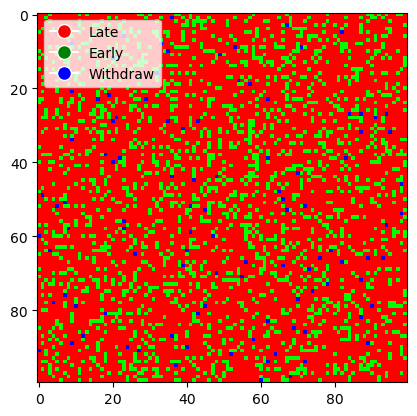

In [134]:
n = 100
p = 0.2
q = 0.3
D = 2
r1 = 1.5
p_panic = 0.01

game = Game(n, p, q, D, r1, p_panic)
game.plot_agent_action_lattice()

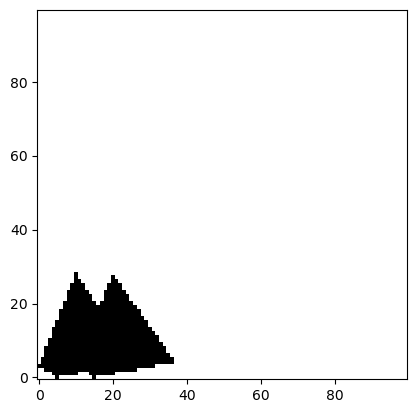

In [135]:
# creating shock
def fill(A, B, fill_below=True, xs=10, ys=12):

    # the equation for a line is y = m*x + b, so calculate
    # m and b from the two points on the line
    m = (B[1]-A[1])/(B[0]-A[0]) # m = (y2 - y1)/(x2 - x1) = slope
    b = A[1] - m*A[0]           # b = y1 - m*x1 = y intercept

    # for each points of the grid, calculate whether it's above, below, or on
    # the line. Since y = m*x + b, calculating m*x + b - y will give
    # 0 when on the line, <0 when above, and >0 when below
    Y, X = np.mgrid[0:ys, 0:xs] 
    L = m*X + b - Y

    # select whether, >=0 is True, or, <=0 is True, to determine whether to
    # fill above or below the line
    op = np.greater_equal if fill_below else np.less_equal
    return op(L, 0.0)

r = fill((0, 3), (10, 28), True, 100, 100) & \
fill((10, 28), (27, 4), True, 100, 100) & \
fill((27,4), (5,0), False, 100, 100) & \
fill((5,0), (0,3), False, 100, 100) | ( \
    fill((10, 3), (20, 28), True, 100, 100) & \
fill((20, 28), (37, 4), True, 100, 100) & \
fill((37,4), (15,0), False, 100, 100) & \
fill((15,0), (10,3), False, 100, 100) 
)
plt.imshow(r, cmap='Greys',  interpolation='nearest', origin='lower')

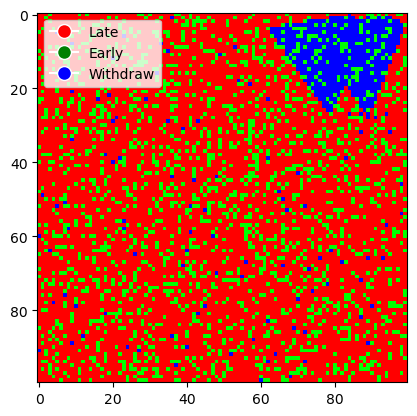

In [136]:
# adding shock

game.exog_shock(np.fliplr(r))

game.plot_agent_action_lattice()

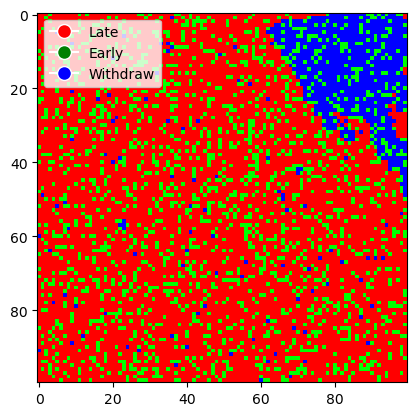

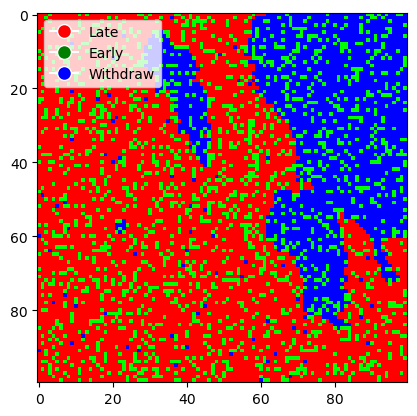

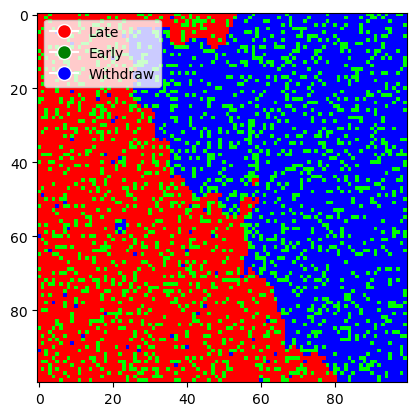

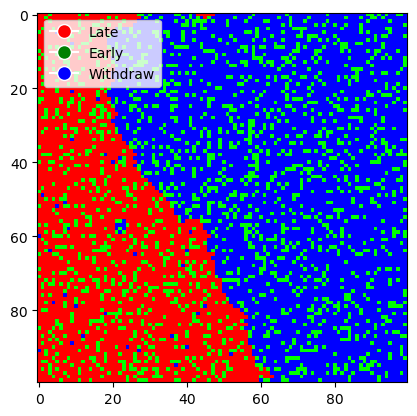

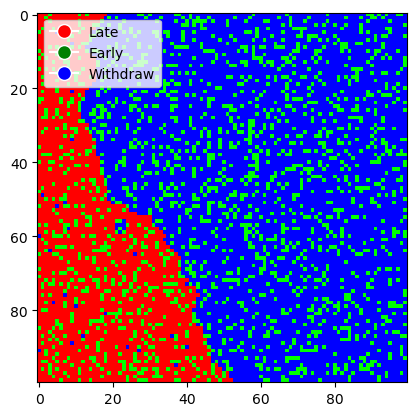

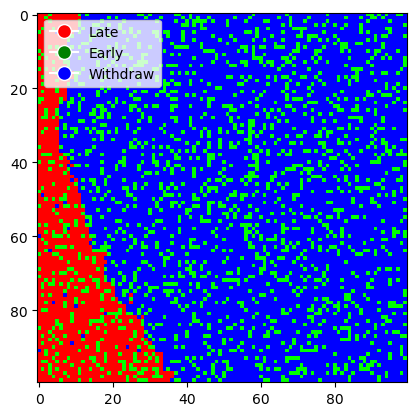

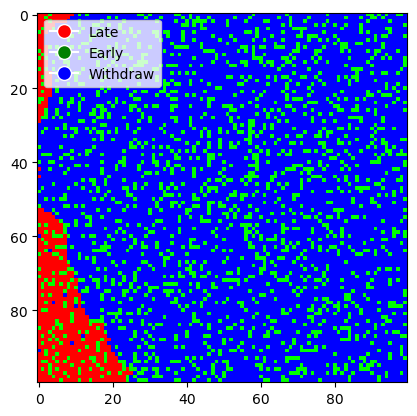

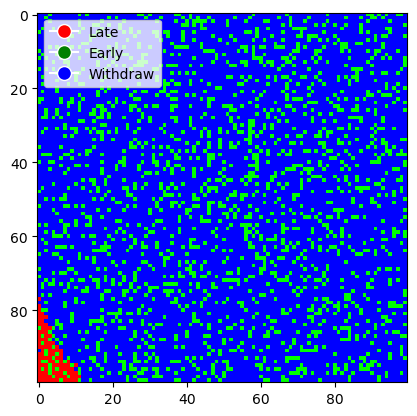

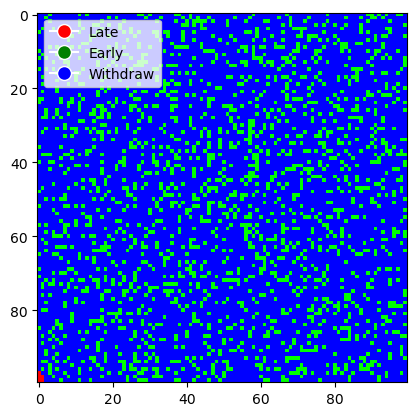

In [137]:
i = 0
while game.play_once() != 0:
    if i % 5 == 0:
        game.plot_agent_action_lattice()
    i += 1

In [138]:
game.play_until_convergence()

{'iters': 1, 'is_bank_run': True}

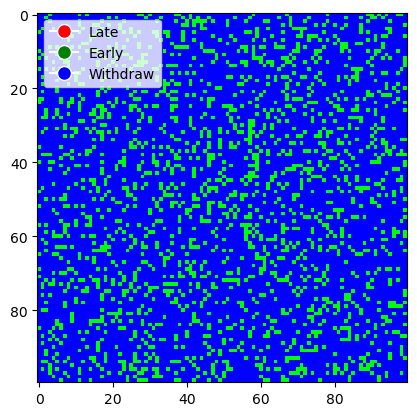

In [139]:
game.plot_agent_action_lattice()

In [140]:
game.is_bank_run()

True